In [1]:
#Importing needed libraries
import requests
import pandas as pd
from datetime import datetime
import geopandas as gpd
import fiona
import time
from json import JSONDecodeError
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.discrete.count_model import ZeroInflatedPoisson
from personal_lib import general_functions as gf
import re
from typing import Optional, List, Tuple
import googlemaps
import os
import math
import pyogrio
import geopandas as gpd
import io



# creds = gf.get_creds()
# google_api_key = creds["Google"]["geocoding"]
# open_ai = creds["openai"]["FirstTestKey"]
# gmaps = googlemaps.Client(key=google_api_key)

# STATE_ABBR = "NY"
# pd.options.display.max_columns = 500 
# from geopy.geocoders import Nominatim
# geolocator = Nominatim(user_agent="capstone_test")

C:\Users\johnf\AppData\Roaming\Python\Python310\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
## Reading in the Prepped Data from parts 1 and 2 
trees_data = pd.read_csv("trees_processed_for_part3.csv")
buildings_data = pd.read_csv("final_building_energy_data.csv") 

C:\Users\johnf\AppData\Local\Temp\ipykernel_42464\3298577332.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  trees_data = pd.read_csv("trees_processed_for_part3.csv")


In [3]:
### Limit to 2010 and 2017  for draft, also because 2012 is bizzarely low. Must keep the same buildings in both years.
working_buildings = buildings_data[buildings_data['year_ending_year'].isin([2010,2017])]
### We only want those with actual energy usages vals 
working_buildings = working_buildings[~working_buildings["weather_normalized_site_eui"].isnull()]
## keep the same buildingd in both years 
working_buildings2 = working_buildings[(
    (working_buildings['bbl'].isin(working_buildings['bbl'][working_buildings['year_ending_year']==2010].unique()))
    &(working_buildings['bbl'].isin(working_buildings['bbl'][working_buildings['year_ending_year']==2017].unique()))
)]


In [4]:
working_buildings2.groupby(["canopy_change_class","year_ending_year"]).agg({"bbl":"nunique"})

bbl
canopy_change_class year_ending_year     
Gain                2010              202
                    2017              200
Loss                2010               40
                    2017               40
No Change           2010              315
                    2017              315

In [5]:
## Limiting to the columnd relevant for the analysis
core_columns = ['year_ending_year', 'property_id', 'bbl', 'address_1', 'address_2', 'city','boroname','ct2010',
                'latitude', 'longitude','geocode_key',
                'year_built','NumFloors','UnitsRes', 'stories','weather_normalized_site_eui',  'canopy_change_class']
working_buildings_lim = working_buildings2[core_columns]

### pulling in the Building Footprint Data

In [6]:
### pulling in the building footprint data
# Full NYC building footprints as GeoJSON
url_geojson = (
    "https://data.cityofnewyork.us/api/geospatial/5zhs-2jue"
    "?method=export&format=GeoJSON"
)

gdf = gpd.read_file(url_geojson)

In [7]:
### Filter for those 
# Make sure last_edited_date is datetime
# Parse as UTC
gdf["last_edited_date"] = pd.to_datetime(gdf["last_edited_date"], errors="coerce", utc=True)

cutoff = pd.Timestamp("2017-12-31", tz="UTC")

gdf = gdf[
    (gdf["last_status_type"] == "Constructed") &
    (gdf["last_edited_date"] <= cutoff) &
    (gdf["mappluto_bbl"].notna())
].copy()

# Then get latest per BBL
gdf_latest = (
    gdf.sort_values("last_edited_date")
       .drop_duplicates(subset="mappluto_bbl", keep="last")
       .copy()
)


In [8]:
# Convert both to string, strip, drop any .0, and zero-fill to 10 digits (if appropriate)
working_buildings_lim["bbl"] = (
    working_buildings_lim["bbl"]
    .astype(str)
    .str.strip()
    .str.split(".").str[0]
    .str.zfill(10)
)

gdf_latest["mappluto_bbl"] = (
    gdf_latest["mappluto_bbl"]
    .astype(str)
    .str.strip()
    .str.split(".").str[0]
    .str.zfill(10)
)

buildings_w_footprints = working_buildings_lim.merge(gdf_latest, how ='inner', left_on = ["bbl"],right_on=["mappluto_bbl"])
buildings_w_footprints = buildings_w_footprints[~buildings_w_footprints["mappluto_bbl"].isnull()]

C:\Users\johnf\AppData\Local\Temp\ipykernel_42464\1114691396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_buildings_lim["bbl"] = (


In [9]:
buildings_w_footprints.drop_duplicates()

,year_ending_year,property_id,bbl,address_1,address_2,city,boroname,ct2010,latitude,longitude,...,objectid,feature_code,shape_length,height_roof,last_status_type,bin,last_edited_date,geom_source,doitt_id,geometry
0,2010,2552023.0,1022020009,420 West 206th Street,NaN,New York,Manhattan,29900,40.863241,-73.918106,...,528862,2100,299.41991833979955,64.82,Constructed,1064502,2017-08-22 19:09:33+00:00,Photogrammetric,608009,"MULTIPOLYGON (((-73.91887 40.86339, -73.91882 ..."
2,2010,20648919.0,1014390042,320 East 65th Street,NaN,New York,Manhattan,11800,40.764066,-73.960919,...,924344,2100,151.7675834970091,80.49,Constructed,1044706,2017-08-22 19:26:22+00:00,Photogrammetric,679603,"MULTIPOLYGON (((-73.96063 40.76387, -73.96067 ..."
3,2010,6726841.0,1014390042,320 East 65th Street,NaN,New York,Manhattan,11800,40.764066,-73.960919,...,924344,2100,151.7675834970091,80.49,Constructed,1044706,2017-08-22 19:26:22+00:00,Photogrammetric,679603,"MULTIPOLYGON (((-73.96063 40.76387, -73.96067 ..."
4,2010,4917680.0,1014390042,320 East 65th Street,NaN,New York,Manhattan,11800,40.764066,-73.960919,...,924344,2100,151.7675834970091,80.49,Constructed,1044706,2017-08-22 19:26:22+00:00,Photogrammetric,679603,"MULTIPOLYGON (((-73.96063 40.76387, -73.96067 ..."
6,2010,4947652.0,3011700001,50 Plaza Street East,NaN,Brooklyn,Brooklyn,20700,40.674831,-73.969065,...,715285,2100,188.44017604905312,137.4,Constructed,3029312,2017-08-22 15:38:41+00:00,Photogrammetric,202831,"MULTIPOLYGON (((-73.96913 40.6751, -73.96913 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3392,2017,3115124.0,2032230030,130 West 183rd Street,NaN,Bronx,Bronx,25500,40.860169,-73.910269,...,768747,2100,256.94591164431313,66.35,Constructed,2014901,2017-08-22 17:44:25+00:00,Photogrammetric,582717,"MULTIPOLYGON (((-73.91042 40.86013, -73.91048 ..."
3394,2017,4978595.0,2057920430,"530 WEST 236 STREET,",NaN,BRONX,Bronx,29500,40.886429,-73.908277,...,234578,2100,369.36815649658092,61.61,Constructed,2084147,2017-08-22 18:03:40+00:00,Photogrammetric,312958,"MULTIPOLYGON (((-73.90851 40.88638, -73.9084 4..."
3396,2017,6694984.0,4067110027,150-15 79th ave,NaN,Queens,Queens,77904,40.720027,-73.813198,...,647509,2100,275.6113356720245,66.13,Constructed,4145164,2017-08-22 19:06:46+00:00,Photogrammetric,269782,"MULTIPOLYGON (((-73.8127 40.72053, -73.81259 4..."
3409,2017,6696738.0,3022447501,2 Lorimer Street,NaN,Brooklyn,Brooklyn,53100,40.700256,-73.953805,...,49332,2100,72.81724164294873,47.78,Constructed,3345995,2017-08-22 15:58:59+00:00,Photogrammetric,925432,"MULTIPOLYGON (((-73.95181 40.70076, -73.95189 ..."


In [10]:
print(working_buildings_lim.shape)
print(buildings_w_footprints.shape)
### ~225 rows lost 

(3652, 17)
(3413, 33)


In [11]:
buildings_w_footprints

,year_ending_year,property_id,bbl,address_1,address_2,city,boroname,ct2010,latitude,longitude,...,objectid,feature_code,shape_length,height_roof,last_status_type,bin,last_edited_date,geom_source,doitt_id,geometry
0,2010,2552023.0,1022020009,420 West 206th Street,NaN,New York,Manhattan,29900,40.863241,-73.918106,...,528862,2100,299.41991833979955,64.82,Constructed,1064502,2017-08-22 19:09:33+00:00,Photogrammetric,608009,"MULTIPOLYGON (((-73.91887 40.86339, -73.91882 ..."
1,2010,2552023.0,1022020009,420 West 206th Street,NaN,New York,Manhattan,29900,40.863241,-73.918106,...,528862,2100,299.41991833979955,64.82,Constructed,1064502,2017-08-22 19:09:33+00:00,Photogrammetric,608009,"MULTIPOLYGON (((-73.91887 40.86339, -73.91882 ..."
2,2010,20648919.0,1014390042,320 East 65th Street,NaN,New York,Manhattan,11800,40.764066,-73.960919,...,924344,2100,151.7675834970091,80.49,Constructed,1044706,2017-08-22 19:26:22+00:00,Photogrammetric,679603,"MULTIPOLYGON (((-73.96063 40.76387, -73.96067 ..."
3,2010,6726841.0,1014390042,320 East 65th Street,NaN,New York,Manhattan,11800,40.764066,-73.960919,...,924344,2100,151.7675834970091,80.49,Constructed,1044706,2017-08-22 19:26:22+00:00,Photogrammetric,679603,"MULTIPOLYGON (((-73.96063 40.76387, -73.96067 ..."
4,2010,4917680.0,1014390042,320 East 65th Street,NaN,New York,Manhattan,11800,40.764066,-73.960919,...,924344,2100,151.7675834970091,80.49,Constructed,1044706,2017-08-22 19:26:22+00:00,Photogrammetric,679603,"MULTIPOLYGON (((-73.96063 40.76387, -73.96067 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408,2017,2800754.0,4019560029,60-15 Calloway St,NaN,Rego Park,Queens,43702,40.737232,-73.855744,...,490567,2100,240.07306165704858,79.57,Constructed,4048141,2017-08-22 18:33:00+00:00,Photogrammetric,79265,"MULTIPOLYGON (((-73.85548 40.73753, -73.85527 ..."
3409,2017,6696738.0,3022447501,2 Lorimer Street,NaN,Brooklyn,Brooklyn,53100,40.700256,-73.953805,...,49332,2100,72.81724164294873,47.78,Constructed,3345995,2017-08-22 15:58:59+00:00,Photogrammetric,925432,"MULTIPOLYGON (((-73.95181 40.70076, -73.95189 ..."
3410,2017,4512100.0,3067590034,1580 EAST 13 ST,NaN,BROOKLYN,Brooklyn,54200,40.610949,-73.960594,...,377967,2100,227.21823633926655,65.13,Constructed,3181718,2017-08-22 15:35:47+00:00,Photogrammetric,443335,"MULTIPOLYGON (((-73.96088 40.6112, -73.96087 4..."
3411,2017,4512100.0,3067590034,1580 EAST 13 ST,NaN,BROOKLYN,Brooklyn,54200,40.610949,-73.960594,...,377967,2100,227.21823633926655,65.13,Constructed,3181718,2017-08-22 15:35:47+00:00,Photogrammetric,443335,"MULTIPOLYGON (((-73.96088 40.6112, -73.96087 4..."


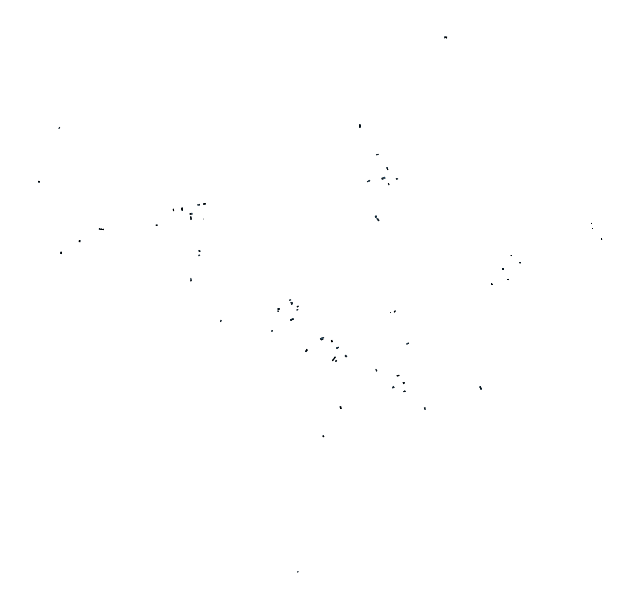

In [12]:
test_gdf = gpd.GeoDataFrame(buildings_w_footprints, geometry="geometry", crs=gdf.crs)

# Keep only rows that actually have geometry
test_gdf = test_gdf[~test_gdf.geometry.isna()].copy()
queens = test_gdf[test_gdf["boroname"] == "Queens"].sample(n=200, random_state=0)

fig, ax = plt.subplots(figsize=(8, 8))
queens.plot(ax=ax, edgecolor="black", linewidth=0.3)
ax.set_axis_off()
plt.show()


In [13]:
### new coutns after join with footprint
buildings_w_footprints.groupby(["canopy_change_class","year_ending_year"]).agg({"bbl":"nunique"})

bbl
canopy_change_class year_ending_year     
Gain                2010              188
                    2017              186
Loss                2010               35
                    2017               35
No Change           2010              284
                    2017              284

In [14]:
### Adding in ttrees with spatial join 

In [15]:
## Same Year limit on trees
working_trees = trees_data[trees_data["manual_year"].isin([2010,2017])]
working_trees

,objectid,dbh,tpstructure,tpcondition,plantingspaceglobalid,geometry,globalid,genusspecies,createddate,location,...,riskrating,riskratingdate,planteddate,lat,lon,removal_date_est,removed_before_2018,removal_year,include_in_year,manual_year
0,230120,0.0,Retired,Unknown,B9DDFFE7-7387-4923-91EA-6E9212AA324F,POINT(-73.72963593901264 40.69403944537182),039E4FD7-CFB6-4518-9E16-1E37D10C994A,Unknown - Unknown,2015-06-19 10:39:00,"{'type': 'Point', 'coordinates': [-73.72963593...",...,NaN,NaN,NaN,40.694039,-73.729636,NaN,False,NaN,NaN,2010
1,746627,18.0,Full,Good,CCD7CEB4-D7FC-427F-982C-55355AB0989D,POINT(-73.93851920790104 40.60738960999758),FF71F967-C0E7-478E-BD3A-C54A2927A624,Acer - maple,2015-09-04 14:54:00,"{'type': 'Point', 'coordinates': [-73.93851920...",...,NaN,NaN,NaN,40.607390,-73.938519,NaN,False,NaN,NaN,2010
2,1058526,14.0,Full,Good,12AA0ADA-517C-4726-905A-E0A5A98EBCC2,POINT(-73.94958994062151 40.72358613049737),7AD3859E-4A1C-4C72-A4B1-F0AC2A97DB0E,Pinus - pine,2015-10-01 14:06:48,"{'type': 'Point', 'coordinates': [-73.94958994...",...,NaN,NaN,NaN,40.723586,-73.949590,NaN,False,NaN,NaN,2010
3,1392285,2.0,Full,Good,560979A5-0B59-46A5-A16E-8FDE0A01875D,POINT(-73.96235422914798 40.7946082222144),ECF53949-832B-4D61-B3C1-DD3042031E87,Quercus palustris - pin oak,2015-10-29 12:29:49,"{'type': 'Point', 'coordinates': [-73.96235422...",...,NaN,NaN,NaN,40.794608,-73.962354,NaN,False,NaN,NaN,2010
4,1415194,6.0,Full,Good,20EE5761-8B78-45D5-8EEE-81C335E5384E,POINT(-73.76501171400223 40.75057879438073),25DF6E74-6BED-45DC-978B-EAF670E0F365,Morus - mulberry,2015-10-29 13:49:57,"{'type': 'Point', 'coordinates': [-73.76501171...",...,NaN,NaN,NaN,40.750579,-73.765012,NaN,False,NaN,NaN,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5569199,5782313,3.0,Full,Good,5BB1F270-B6E0-4EB0-A998-E528605E93DF,POINT(-73.94682076785342 40.585317039825405),0598CDAF-0DEC-4E5D-BC0A-90831E9DF202,Pyrus calleryana 'Chanticleer' - 'Chanticleer'...,2017-12-11 00:00:00,"{'type': 'Point', 'coordinates': [-73.94682076...",...,NaN,NaN,NaN,40.585317,-73.946821,NaN,False,NaN,NaN,2017
5569200,5787952,3.0,Full,Good,71BD3EDA-6B99-45CC-8602-192D43C0548C,POINT(-73.8228103286091 40.70357559309544),77AC65C0-F876-443F-A59A-5179623A45C0,Zelkova serrata 'Mushashino' - 'Mushashino' Ze...,2017-05-17 00:00:00,"{'type': 'Point', 'coordinates': [-73.82281032...",...,3.0,2019-07-30 14:34:32,NaN,40.703576,-73.822810,NaN,False,NaN,NaN,2017
5569201,5787133,3.0,Full,Good,A2DD01E4-827D-4551-BA8B-7897F33E059E,POINT(-73.94297748515692 40.58612917453949),932FCCA1-CF52-4733-953F-54C4B05E50D5,Ginkgo biloba 'Autumn Gold' - 'Autumn Gold' Gi...,2017-12-11 00:00:00,"{'type': 'Point', 'coordinates': [-73.94297748...",...,NaN,NaN,NaN,40.586129,-73.942977,NaN,False,NaN,NaN,2017
5569202,5787679,4.0,Retired,Good,964DB6FF-08AF-426B-A30C-B13802F9EF28,POINT(-73.9962117329861 40.758407615772356),CFEFAF62-5A0E-4D47-9884-06044DA376D0,Ulmus parvifolia - Chinese elm,2017-06-21 00:00:00,"{'type': 'Point', 'coordinates': [-73.99621173...",...,7.0,2021-11-09 17:16:00,NaN,40.758408,-73.996212,NaN,False,NaN,NaN,2017


In [16]:
# Re-wrap as GeoDataFrame
buildings_gdf = gpd.GeoDataFrame(
    buildings_w_footprints,
    geometry="geometry",
    crs="EPSG:2263"   # adjust if you know it's something else
)

print("Buildings CRS:", buildings_gdf.crs)

# 1) Convert the WKT strings to shapely geometries
working_trees["geometry"] = gpd.GeoSeries.from_wkt(working_trees["geometry"])

# 2) Now build a proper GeoDataFrame.
# These coordinates are lon/lat, so CRS is WGS84 = EPSG:4326
trees_gdf = gpd.GeoDataFrame(
    working_trees,
    geometry="geometry",
    crs="EPSG:4326"
)

print("Trees CRS:", trees_gdf.crs)

Buildings CRS: EPSG:2263


C:\Users\johnf\AppData\Local\Temp\ipykernel_42464\1802187485.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_trees["geometry"] = gpd.GeoSeries.from_wkt(working_trees["geometry"])


Trees CRS: EPSG:4326


In [17]:
buildings_2263 = buildings_gdf.to_crs(epsg=2263)
trees_2263 = trees_gdf.to_crs(epsg=2263)

print("Buildings CRS (projected):", buildings_2263.crs)
print("Trees CRS (projected):", trees_2263.crs)


Buildings CRS (projected): EPSG:2263
Trees CRS (projected): EPSG:2263


In [18]:
print("Buildings bounds:", buildings_2263.total_bounds)
print("Trees bounds:    ", trees_2263.total_bounds)

Buildings bounds: [-74.04046424  40.57675171 -73.7448404   40.90838527]
Trees bounds:     [ 913349.26604189  120962.40437512 1067920.5235419   272357.6285418 ]


In [19]:
# Buildings geometry is clearly lon/lat, so set CRS to WGS84 (4326)
buildings_gdf = gpd.GeoDataFrame(
    buildings_w_footprints,
    geometry="geometry",
    crs="EPSG:4326"
)

# Trees were created from WKT with crs="EPSG:4326" earlier
# trees_gdf = GeoDataFrame(..., crs="EPSG:4326")

# Now reproject BOTH to 2263 (feet)
buildings_2263 = buildings_gdf.to_crs(epsg=2263)
trees_2263     = trees_gdf.to_crs(epsg=2263)

print("Buildings CRS (projected):", buildings_2263.crs)
print("Trees CRS (projected):    ", trees_2263.crs)
print("Buildings bounds:", buildings_2263.total_bounds)
print("Trees bounds:    ", trees_2263.total_bounds)


Buildings CRS (projected): EPSG:2263
Trees CRS (projected):     EPSG:2263
Buildings bounds: [ 973017.11755117  149405.45322918 1054967.26647639  270241.38310097]
Trees bounds:     [ 913349.26604189  120962.40437512 1067920.5235419   272357.6285418 ]


In [20]:
# 50-ft buffer around each building footprint
bldg_buf = buildings_2263[["bbl", "geometry"]].copy()
bldg_buf["geometry"] = bldg_buf.geometry.buffer(50)  # 50 feet

# Spatial join: trees whose point lies inside any 50-ft building buffer
trees_with_bldg = gpd.sjoin(
    trees_2263,
    bldg_buf,
    how="left",
    predicate="within"
)

trees_near_buildings = trees_with_bldg[trees_with_bldg["bbl"].notna()].copy()

print("Trees near buildings:", len(trees_near_buildings))
print(trees_near_buildings.head())


Trees near buildings: 32436
     objectid   dbh tpstructure tpcondition  \
118    223713  19.0        Full        Good   
118    223713  19.0        Full        Good   
118    223713  19.0        Full        Good   
118    223713  19.0        Full        Good   
413    223342  29.0        Full        Fair   

                    plantingspaceglobalid                        geometry  \
118  3B40C908-6A1F-47DD-B0C2-F999E0A72883   POINT (1004520.723 252576.85)   
118  3B40C908-6A1F-47DD-B0C2-F999E0A72883   POINT (1004520.723 252576.85)   
118  3B40C908-6A1F-47DD-B0C2-F999E0A72883   POINT (1004520.723 252576.85)   
118  3B40C908-6A1F-47DD-B0C2-F999E0A72883   POINT (1004520.723 252576.85)   
413  F41BC3FC-C6AA-4955-9A66-A08AE2E83541  POINT (1014945.839 213039.412)   

                                 globalid  \
118  63DE7F53-DB69-45FF-BD5B-95E2311EB6A9   
118  63DE7F53-DB69-45FF-BD5B-95E2311EB6A9   
118  63DE7F53-DB69-45FF-BD5B-95E2311EB6A9   
118  63DE7F53-DB69-45FF-BD5B-95E2311EB6A9   
4

In [23]:
trees_near_buildings.columns

Index(['objectid', 'dbh', 'tpstructure', 'tpcondition',
       'plantingspaceglobalid', 'geometry', 'globalid', 'genusspecies',
       'createddate', 'location', 'stumpdiameter', 'updateddate', 'riskrating',
       'riskratingdate', 'planteddate', 'lat', 'lon', 'removal_date_est',
       'removed_before_2018', 'removal_year', 'include_in_year', 'manual_year',
       'index_right', 'bbl'],
      dtype='object')

In [34]:
trees_near_buildings = trees_near_buildings[((trees_near_buildings['include_in_year'].isnull())
                                             |(trees_near_buildings['include_in_year']==True))].copy()
building_trees_grouped = trees_near_buildings.groupby(['manual_year','bbl','genusspecies']).agg({'objectid':'nunique'}).reset_index()
building_trees_grouped = building_trees_grouped.rename(columns={"objectid":"tree_count"})

In [29]:
buildings_2263

,year_ending_year,property_id,bbl,address_1,address_2,city,boroname,ct2010,latitude,longitude,...,objectid,feature_code,shape_length,height_roof,last_status_type,bin,last_edited_date,geom_source,doitt_id,geometry
0,2010,2552023.0,1022020009,420 West 206th Street,NaN,New York,Manhattan,29900,40.863241,-73.918106,...,528862,2100,299.41991833979955,64.82,Constructed,1064502,2017-08-22 19:09:33+00:00,Photogrammetric,608009,"MULTIPOLYGON (((1006689.457 253842.714, 100670..."
1,2010,2552023.0,1022020009,420 West 206th Street,NaN,New York,Manhattan,29900,40.863241,-73.918106,...,528862,2100,299.41991833979955,64.82,Constructed,1064502,2017-08-22 19:09:33+00:00,Photogrammetric,608009,"MULTIPOLYGON (((1006689.457 253842.714, 100670..."
2,2010,20648919.0,1014390042,320 East 65th Street,NaN,New York,Manhattan,11800,40.764066,-73.960919,...,924344,2100,151.7675834970091,80.49,Constructed,1044706,2017-08-22 19:26:22+00:00,Photogrammetric,679603,"MULTIPOLYGON (((995155.955 217577.131, 995146...."
3,2010,6726841.0,1014390042,320 East 65th Street,NaN,New York,Manhattan,11800,40.764066,-73.960919,...,924344,2100,151.7675834970091,80.49,Constructed,1044706,2017-08-22 19:26:22+00:00,Photogrammetric,679603,"MULTIPOLYGON (((995155.955 217577.131, 995146...."
4,2010,4917680.0,1014390042,320 East 65th Street,NaN,New York,Manhattan,11800,40.764066,-73.960919,...,924344,2100,151.7675834970091,80.49,Constructed,1044706,2017-08-22 19:26:22+00:00,Photogrammetric,679603,"MULTIPOLYGON (((995155.955 217577.131, 995146...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408,2017,2800754.0,4019560029,60-15 Calloway St,NaN,Rego Park,Queens,43702,40.737232,-73.855744,...,490567,2100,240.07306165704858,79.57,Constructed,4048141,2017-08-22 18:33:00+00:00,Photogrammetric,79265,"MULTIPOLYGON (((1024301.166 208010.579, 102435..."
3409,2017,6696738.0,3022447501,2 Lorimer Street,NaN,Brooklyn,Brooklyn,53100,40.700256,-73.953805,...,49332,2100,72.81724164294873,47.78,Constructed,3345995,2017-08-22 15:58:59+00:00,Photogrammetric,925432,"MULTIPOLYGON (((997612.426 194585.156, 997588...."
3410,2017,4512100.0,3067590034,1580 EAST 13 ST,NaN,BROOKLYN,Brooklyn,54200,40.610949,-73.960594,...,377967,2100,227.21823633926655,65.13,Constructed,3181718,2017-08-22 15:35:47+00:00,Photogrammetric,443335,"MULTIPOLYGON (((995111.532 161957.235, 995113...."
3411,2017,4512100.0,3067590034,1580 EAST 13 ST,NaN,BROOKLYN,Brooklyn,54200,40.610949,-73.960594,...,377967,2100,227.21823633926655,65.13,Constructed,3181718,2017-08-22 15:35:47+00:00,Photogrammetric,443335,"MULTIPOLYGON (((995111.532 161957.235, 995113...."


In [35]:
building_trees_all = buildings_2263.merge(building_trees_grouped,
                                          how='inner',
                                          right_on=['manual_year','bbl'],left_on = ['year_ending_year','bbl'])

In [47]:
building_trees_all_lim =building_trees_all[["year_ending_year","bbl",'year_built', 'NumFloors', 'UnitsRes', 'stories',"construction_year",
                   "ground_elevation","height_roof","weather_normalized_site_eui","genusspecies","tree_count"]].drop_duplicates()
building_trees_all_lim = building_trees_all_lim.rename(columns={"year_ending_year":"year"})
building_trees_all_lim["year_built"] = building_trees_all_lim["year_built"].combine_first(building_trees_all_lim["construction_year"]).astype(int)
## Singluwer Null building for Num floors
building_trees_all = building_trees_all[~building_trees_all['NumFloors'].isnull()]
building_trees_all_lim = building_trees_all_lim.drop(columns=["construction_year"])

In [49]:
building_trees_all_lim.to_csv('analysis_file.csv',index=False)

In [68]:
building_trees_all_lim

,year,bbl,year_built,NumFloors,UnitsRes,stories,ground_elevation,height_roof,weather_normalized_site_eui,genusspecies,tree_count
0,2010,1022020009,1946,6.0,74.0,6.0,11,64.82,99.5,Platanus x acerifolia - London planetree,3
1,2010,1022020009,1946,6.0,74.0,6.0,11,64.82,99.5,Quercus rubra - northern red oak,1
2,2010,1022020009,1946,6.0,74.0,6.0,11,64.82,99.5,Tilia americana - American basswood,2
6,2010,1014390042,1930,9.0,71.0,9.0,49,80.49,71.3,Gleditsia triacanthos var. inermis - Thornless...,8
7,2010,1014390042,1930,9.0,71.0,9.0,49,80.49,71.3,Taxodium distichum - bald cypress,1
...,...,...,...,...,...,...,...,...,...,...,...
7440,2017,3022447501,1998,5.0,112.0,5.0,10,47.78,52.7,Gleditsia triacanthos var. inermis - Thornless...,3
7441,2017,3022447501,1998,5.0,112.0,5.0,10,47.78,52.7,Pyrus calleryana - Callery pear,1
7442,2017,3022447501,1998,5.0,112.0,5.0,10,47.78,52.7,Tilia tomentosa - silver linden,1
7443,2017,3067590034,1961,6.0,84.0,6.0,27,65.13,81.3,Acer platanoides - Norway maple,1


### Analysis / Modeling Start  (Remember to pull Canopy back in when needed)

In [50]:
bldg_year = (
    building_trees_all_lim.groupby(["bbl", "year"], as_index=False)
      .agg({
          "year_built": "first",
          "NumFloors": "first",
          "UnitsRes": "first",
          "stories": "first",
          "ground_elevation": "first",
          "height_roof": "first",
          "weather_normalized_site_eui": "first",
          "tree_count": "sum"   # sum of all species
      })
      .rename(columns={"tree_count": "trees_50ft"})
)
bldg_year["age_at_year"] = bldg_year["year"] - bldg_year["year_built"]
bldg_year["log_units"]   = np.log1p(bldg_year["UnitsRes"])

In [52]:
#Looking at Energy Values 
print(bldg_year.groupby("year")["weather_normalized_site_eui"].describe())
print(bldg_year.groupby("year")["trees_50ft"].describe())


      count        mean          std  min    25%   50%     75%      max
year                                                                   
2010  471.0  297.572824  3284.307776  1.2  67.85  83.1  100.95  50583.5
2017  471.0   84.210828    31.720000  0.1  69.90  82.4   97.20    374.7
      count      mean       std  min  25%  50%   75%   max
year                                                      
2010  471.0  7.373673  4.453121  1.0  4.0  6.0  10.0  38.0
2017  471.0  7.518047  4.609795  1.0  4.0  6.0  10.0  32.0


In [53]:
bldg_year["tree_quantile"] = pd.qcut(bldg_year["trees_50ft"], 4, labels=["Q1","Q2","Q3","Q4"])

(
    bldg_year
    .groupby(["year", "tree_quantile"])["weather_normalized_site_eui"]
    .mean()
    .unstack("tree_quantile")
)


C:\Users\johnf\AppData\Local\Temp\ipykernel_42464\4205278050.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["year", "tree_quantile"])["weather_normalized_site_eui"]


tree_quantile,Q1,Q2,Q3,Q4
year,,,,
2010,84.550758,83.887273,463.444361,605.525000
2017,86.766418,83.692661,81.698413,84.510784


In [54]:
import statsmodels.formula.api as smf

# Use year as a categorical fixed effect
bldg_year["year_cat"] = bldg_year["year"].astype("category")

formula = """
weather_normalized_site_eui ~
    trees_50ft +
    log_units +
    stories +
    age_at_year +
    ground_elevation +
    height_roof +
    C(year_cat)
"""

model = smf.ols(formula, data=bldg_year).fit(cov_type="HC3")  # robust SEs
print(model.summary())


C:\Python310\lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 601, but rank is 473
  warnings.warn('covariance of constraints does not have full '


                                 OLS Regression Results                                
Dep. Variable:     weather_normalized_site_eui   R-squared:                       0.501
Model:                                     OLS   Adj. R-squared:                 -0.001
Method:                          Least Squares   F-statistic:                     9.077
Date:                         Sun, 09 Nov 2025   Prob (F-statistic):          2.72e-107
Time:                                 19:55:50   Log-Likelihood:                -8310.0
No. Observations:                          942   AIC:                         1.757e+04
Df Residuals:                              469   BIC:                         1.986e+04
Df Model:                                  472                                         
Covariance Type:                           HC3                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
------------------

In [55]:
# Wide form by bbl
wide = (
    bldg_year
    .pivot(index="bbl", columns="year", values=["weather_normalized_site_eui", "trees_50ft"])
)

# Keep only complete pairs
wide = wide.dropna()

eui_2010 = wide["weather_normalized_site_eui"][2010]
eui_2017 = wide["weather_normalized_site_eui"][2017]
trees_2010 = wide["trees_50ft"][2010]
trees_2017 = wide["trees_50ft"][2017]

delta = pd.DataFrame({
    "bbl": wide.index,
    "delta_eui":  eui_2017 - eui_2010,
    "delta_trees": trees_2017 - trees_2010,
    "trees_2010": trees_2010,
    "trees_2017": trees_2017
})

# Optional: drop huge outliers if you see insane values
delta = delta[(delta["delta_eui"].between(-500, 500))]

# Simple change regression
model_delta = smf.ols("delta_eui ~ delta_trees", data=delta).fit(cov_type="HC3")
print(model_delta.summary())


                            OLS Regression Results                            
Dep. Variable:              delta_eui   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7112
Date:                Sun, 09 Nov 2025   Prob (F-statistic):              0.399
Time:                        19:56:53   Log-Likelihood:                -2459.7
No. Observations:                 469   AIC:                             4923.
Df Residuals:                     467   BIC:                             4932.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.7830      2.130      0.368      

In [59]:
model_delta2 = smf.ols("delta_eui ~ delta_trees + trees_2010", data=delta).fit()
print(model_delta2.summary())

                            OLS Regression Results                            
Dep. Variable:              delta_eui   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.3853
Date:                Sun, 09 Nov 2025   Prob (F-statistic):              0.680
Time:                        19:57:40   Log-Likelihood:                -2459.6
No. Observations:                 469   AIC:                             4925.
Df Residuals:                     466   BIC:                             4938.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1541      4.256      0.036      

### Rand Forest

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Feature set (you can tweak this)
X = bldg_year[[
    "trees_50ft", "log_units", "stories", "age_at_year",
    "ground_elevation", "height_roof", "year"
]]
y = bldg_year["weather_normalized_site_eui"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

# Feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances)


R²: -0.20624796887786645
MAE: 335.73455901060066
height_roof         0.295151
trees_50ft          0.225789
age_at_year         0.175614
year                0.103863
log_units           0.085500
ground_elevation    0.083744
stories             0.030338
dtype: float64
